In [1]:
%pylab inline
import scipy

from pyiga import bspline, assemble, geometry, vis

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


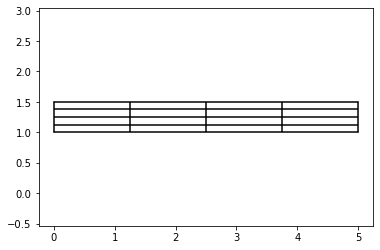

In [2]:
# undeformed stick
geo = geometry.tensor_product(geometry.line_segment(1,1.5), geometry.line_segment(0,5, intervals=3))
vis.plot_geo(geo, grid=5)
axis('equal');

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

def plot_grid(x,y, ax=None, **kwargs):
    ax = ax or plt.gca()
    segs1 = np.stack((x,y), axis=2)
    segs2 = segs1.transpose(1,0,2)
    ax.add_collection(LineCollection(segs1, **kwargs))
    ax.add_collection(LineCollection(segs2, **kwargs))
    ax.autoscale()


In [4]:
# rubber, Lamé-coeff.
Mu = 0.003 # [GPa]
Lam = 0.00028416 #  [GPa] (under ass. ny=0.48, almost incompressible)

def linelast_vf(dim):
    from pyiga.vform import VForm, grad, inner, div, dx
    vf = VForm(dim)
    u, v = vf.basisfuns(components=(dim,dim)) # vector valued
    #vf.add(2* Mu *inner(1/2 * (grad(u) + grad(u).T), 1/2 * (grad(v) + grad(v).T)) * dx + Lam * div(u) * div(v)  * dx)
    e_u = 1/2 * (grad(u) + grad(u).T)
    e_v =  1/2 * (grad(v) + grad(v).T)
    vf.add(2* Mu *inner(e_u, e_v) * dx + Lam * div(u) * div(v)  * dx) 
    return vf


In [5]:
# define Dirichlet boundary conditions
def g_def(x, y):  return (0.0, (1-y)*(1.5-y)) # at boundary = 0 , only in 2nd component
def g_zero(x, y): return (0.0, 0.0)
#def g(x, y): return (0,-3e-7) # Neumann BC function
def g0(x,y):
    if (x>4).all():
        return -3e-7 # set force at distal end only
    else:
        return 0
    
def g(x,y):
    if isinstance(x,numpy.float64):
        return (0,g0(x,y))
    return (0,[g0(xi,0) for xi in np.nditer(x)])

In [6]:
f = lambda x,y: (0,0) # source term

In [7]:
# evaluate displacement and "pressure" over a grid in the parameter domain
xgrid = linspace(0, 1, 20)
xygrid = (xgrid, xgrid)

G = geo.grid_eval(xygrid)

# define discretization space
#n_el = (50, 25)   # number of elements in y/x direction
n_el = (50, 10) # istotropic material

In [8]:
def func_p(p, geo, n_el, xygrid):
    kvs_u = tuple(bspline.make_knots(p,  0.0, 1.0, n, mult=1) for n in n_el)
    m_u = tuple(kv.numdofs for kv in kvs_u)
    A = assemble.assemble_vf(linelast_vf(2), kvs_u, geo=geo, symmetric=True)
    bcs = assemble.compute_dirichlet_bcs(kvs_u, geo,
        [('left', g_zero)]) # left: dirichlet boundary cond.
    
    gn= assemble.assemble('inner(g,v)*ds', kvs_u, bfuns=[('v',2)], geo=geo, g=g, boundary='top')
    g2= assemble.boundary_dofs(kvs_u,'top',ravel=True) # gives us all boundary dofs
    shape_a= shape(A)[0]
    nbc= np.zeros(shape(A)[0])
    for i in range(len(g2)):
        nbc[g2[i]]= gn[0,0,i] #gn[0,i,0],gn[0,0,i]
        nbc[g2[i]+shape_a//2]= gn[1,0,i] #gn[1,i,0], gn[1,0,i]
        
    rhs = assemble.inner_products(kvs_u, f, f_physical=True, geo=geo).ravel()
    
    # solve system with the given boundary conditions and 0 right-hand side
    LS = assemble.RestrictedLinearSystem(A, nbc+rhs, bcs) 
    u = scipy.sparse.linalg.spsolve(LS.A, LS.b)
    u = LS.complete(u)
    
    #split the solution into its components (displacement in x- and y- direction)
    N = np.prod(tuple(kv.numdofs for kv in kvs_u))
    u1 = u[:N].reshape(m_u)
    u2 = u[N:2*N].reshape(m_u)
    U = np.stack((u1,u2), axis=-1)
    
    displ = geometry.BSplineFunc(kvs_u, U) 
    dis = displ.grid_eval(xygrid)
    return dis

Compiling C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\modebf2ade4b47fff41.pyx because it changed.
[1/1] Cythonizing C:\Users\MHeig\AppData\Local\pyiga\pyiga\Cache\modules\modebf2ade4b47fff41.pyx


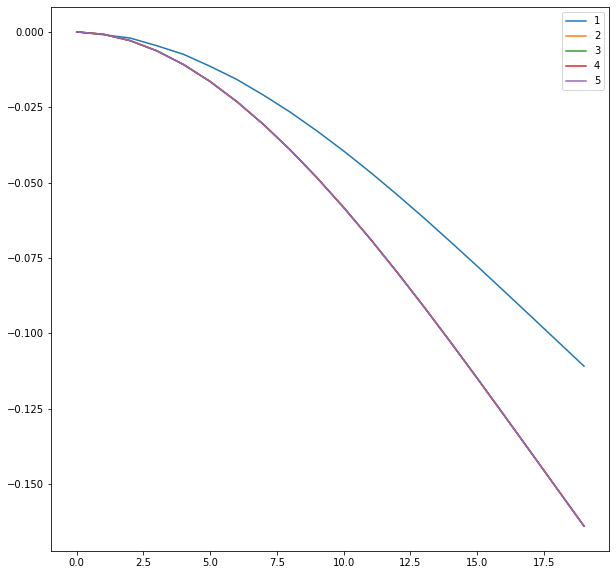

In [9]:
#dis= func_p(3, geo, n_el, xygrid)
figsize(10,10)
for pp in range(1,6):
    dis= func_p(pp, geo, n_el, xygrid)
    y_val=[]
    for i in range(len(dis)):
        y_val = np.append(y_val,dis[0,i,1])
 
    plot(y_val, label=pp )
    
plt.legend()
plt.show()

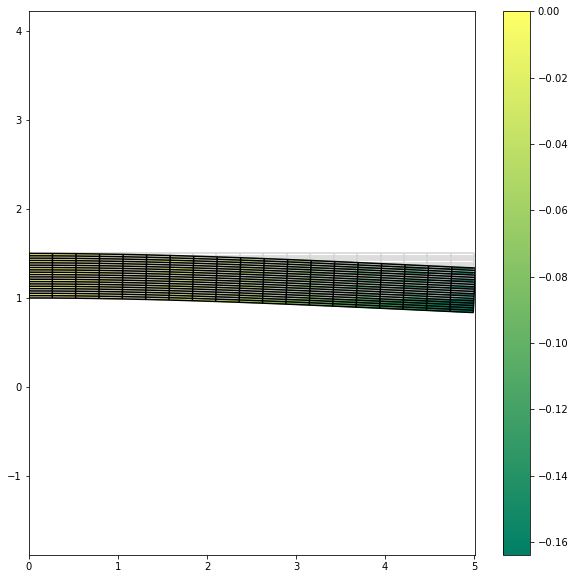

In [10]:
# plot deformation
#plt.subplot(226)
figsize(10,10)
fig, ax = plt.subplots()

dis= func_p(3, geo, n_el, xygrid)

plot_grid(G[...,0], G[...,1], ax=ax, color="lightgrey")
plot_grid(G[...,0]+dis[...,0], G[...,1]+dis[...,1], ax=ax, color="black")

# colormesh w.r.t. displacement & deformed quater annulus
pcolormesh(G[...,0]+dis[...,0], G[...,1]+dis[...,1], dis[...,1], cmap='summer', shading='gouraud');
colorbar();

axis('equal');

In [11]:
h_rate = numpy.linspace(10, 50, 9)
#h_rate = numpy.linspace(10, 50, 5)
print(h_rate)

y_val=np.zeros(len(h_rate))
#x_val=np.zeros(len(h_rate))

[10. 15. 20. 25. 30. 35. 40. 45. 50.]


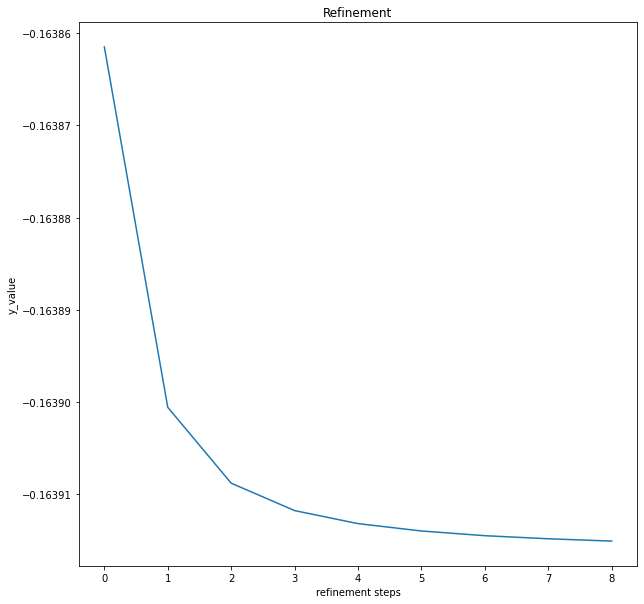

In [14]:
figsize(10,10)

for i in range(0, len(h_rate)):
    #print(h_rate[i])
    n_el = (5*h_rate[i], h_rate[i]) # 5:1
    #print(n_el)
    dis= func_p(2, geo, n_el, xygrid) # p=2 or p=3 fix
    
    def_x=(dis[...,0][19][19])
    def_y = (dis[...,1][19][19])
    
    y_val[i] = def_y
    #x_val[i]= def_x
    
#plot(x_val)
plt.plot(y_val)

plt.title('Refinement')
plt.xlabel('refinement steps')
plt.ylabel('y_value')

#plt.legend()
plt.show()